# Принятие решений в бизнесе. A/B тестирование. Приоритизация гипотез, анализ

Крупному интернет магазину требуется увеличить выручку. Был подготовлен список гипотез, необходимо приоритизировать их, провести A/B тест и провести его анализ.

### Описание данных
*Файл **hypothesis.csv**.*
- **Hypothesis** — краткое описание гипотезы
- **Reach** — охват пользователей по 10-балльной шкале
- **Impact** — влияние на пользователей по 10-балльной шкале
- **Confidence** — уверенность в гипотезе по 10-балльной шкале
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

*Файл **orders.csv**.*
- **transactionId** — идентификатор заказа
- **visitorId** — идентификатор пользователя, совершившего заказ
- **date** — дата, когда был совершён заказ
- **revenue** — выручка заказа
- **group** — группа A/B-теста, в которую попал заказ

*Файл **visitors.csv**.*
- **date** — дата
- **group** — группа A/B-теста
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

## Вывод:
По итогам исследования выявлено, что есть `статистически значимое различие конверсий` групп **A** и **B**. Данное различие прослеживается как по `сырым`, так и по `очищенным` данным. `Конверсия` группы **B** выше примерно на **15%**.\
Что касается различий по размеру `среднего чека`, то их `не выявлено` ни по `сырым`, ни по `очищенным` данным. Следовательно, можно считать, что `средние чеки` данных групп примерно `равны`.\
Исходя из данной информации, а также из данных графиков `выручки`, `кумулятивной конверсии` и `относительного изменения кумулятивной конверсии`, можно принять решение о **победе группы B** и **остановке теста**.

## Обзор данных

In [1]:
# импортируем библиотеки
import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats as st
sns.set()

In [2]:
# читаем файлы csv
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),  # гипотезы
        pd.read_csv('/datasets/orders.csv'),  # заказы
        pd.read_csv('/datasets/visitors.csv'),  # пользователи
    )
except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),  # гипотезы
        pd.read_csv('orders.csv'),  # заказы
        pd.read_csv('visitors.csv'),  # пользователи
    )
display(hypothesis.head(), orders.head(), visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [6]:
# ищем явные дубликаты
display(orders.duplicated().sum(),
      visitors.duplicated().sum())

0

0

##### Вывод:
Пропусков нет, дубликатов нет, необходимо:
- убрать ограничение по ширине отображаемых столбцов и их количеству
- привести наименования колонок к единому стилю
- преобразовать тип данных столбцов с датой

## Предобработка данных

In [7]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [8]:
# приводим названия столбцов к нижнему регистру и единому стилю
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [x.replace('Id', '_id') for x in orders.columns]

In [9]:
# меняем тип данных столбцов с датой
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [10]:
# проверяем результат
display(hypothesis.head(), orders.head(), visitors.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


## Приоритизация гипотез

Отделом маркетинга были подготовлены 9 гипотез по увеличению выручки магазина. Применим фреймворки **ICE** и **RICE** для приоритизации данных гипотез.

In [14]:
# применяем фреймворк ICE
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by='ICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


In [15]:
# применяем фреймворк RICE
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by='RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


##### Вывод:
Оба фреймворка ставят на `4 последних места`, хоть и немного в разной последовательности, гипотезы под номерами **1**, **3**, **4**, **5**. Однако гипотеза, занимающая `1` место по фреймворку **ICE**, занимает только `5` место по фреймворку **RICE**. Причину подобного легко объяснить, так как это гипотеза под номером **8**, предлагающая ввести `скидку на товар в день рождения`. Подобная акция имеет `очень высокое влияние` (**impact**) и `степень уверенности в точности оценок` прочих параметров (**confidence**), однако `охват аудитории` минимальный, так как данная акция будет актуальна для каждого из пользователей только один день в году.\
Также есть небольшие изменения в местах прочих гипотез: гипотеза номер **0** - `вторая` по **ICE**, становится `третьей` по **RICE** так же из-за низкого параметра охвата (**reach**) в совокупности с большими трудозатратами (**efforts**).\
Гипотеза номер **7** - `третья` по **ICE**, становится `первой` по **RICE**, так как форму подписки, расположенную на каждой странице сайта, увидит максимальное количество пользователей.\
А гипотеза номер **2** - `пятая` по **ICE**, становится `второй` по **RICE**.\
В общем, можно отметить, что параметр **reach** имеет `очень высокое влияние` на оценку гипотезы, однако, если прочие параметры будут низкими, а затраты (**efforts**) наоборот высокими, то гипотеза получит низкую оценку - пример гипотеза номер **3**, которая при **reach** = 8, оказалась только на `6` месте.

## Анализ

### Кумулятивные метрики

#### Кумулятивная выручка

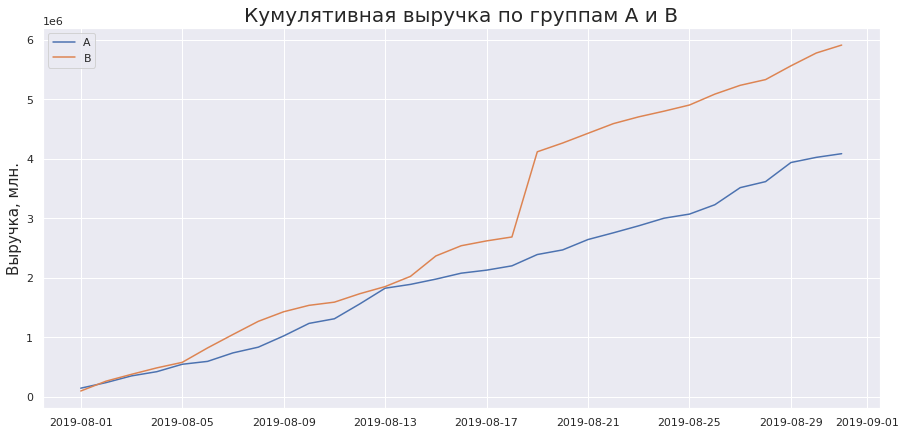

In [16]:
# создаем массив уникальных пар значений дат и групп теста
dates_grouped = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_aggregated = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(
    visitors_aggregated,
    left_on=['date', 'group'],
    right_on=['date', 'group'])

cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_RevenueA = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_RevenueB = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

# строим график выручки группы А
plt.figure(figsize=(15,7))
plt.plot(cumulative_RevenueA['date'], cumulative_RevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulative_RevenueB['date'], cumulative_RevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам А и В', fontsize=20)
plt.ylabel('Выручка, млн.', fontsize=15)
plt.legend() 
plt.show()

По графику видим, что `выручка` группы **A** `растёт более плавно`, однако практически с самого начала `уступает` выручке группы **B**. Также у группы **B** виден `резкий скачок` 18 августа, что может свидетельствовать об `увеличении количества или стоимости` оформляемых заказов, либо об `ошибке` в данных или `выбросе`.

#### Кумулятивный средний чек

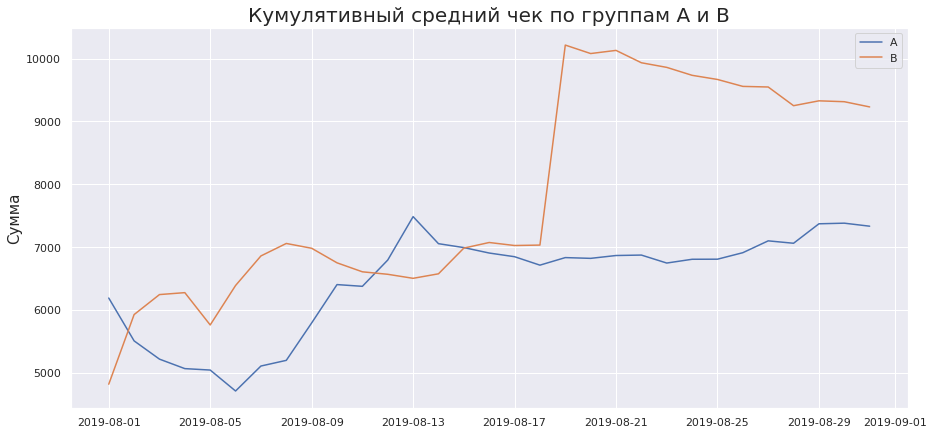

In [17]:
# строим графики кумулятивного среднего чека по дням
plt.figure(figsize=(15,7))
plt.plot(cumulative_RevenueA['date'], cumulative_RevenueA['revenue'] / cumulative_RevenueA['orders'], label='A')
plt.plot(cumulative_RevenueB['date'], cumulative_RevenueB['revenue'] / cumulative_RevenueB['orders'], label='B')

plt.title('Кумулятивный средний чек по группам А и В', fontsize=20)
plt.ylabel('Сумма', fontsize=15)
plt.legend() 
plt.show()

По графику `среднего чека` также виден `резкий скачок` 18 августа у группы **B**, после чего показатель `начинает снижаться`.

#### Изменение кумулятивного среднего чека группы B к группе A.

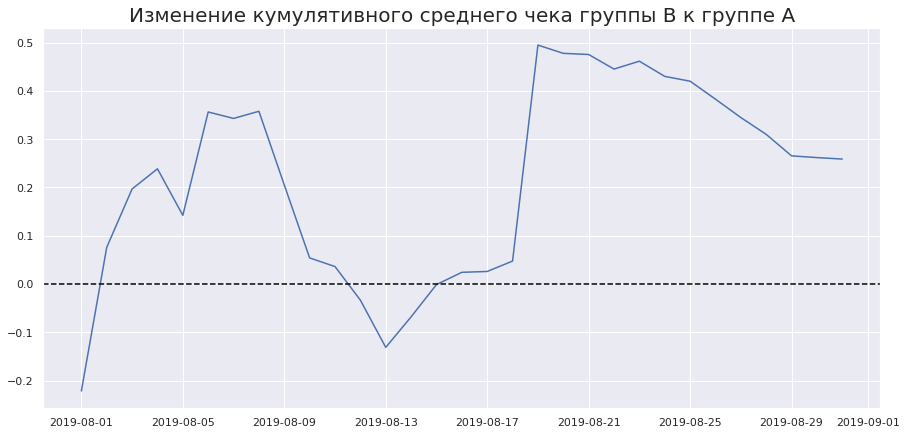

In [18]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_RevenueA.merge(
    cumulative_RevenueB,
    left_on=['date'],
    right_on=['date'],
    how='left',
    suffixes=['A', 'B']
)

# cтроим отношение средних чеков
plt.figure(figsize=(15,7))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB'] / merged_cumulative_revenue['ordersB']) / (merged_cumulative_revenue['revenueA'] / merged_cumulative_revenue['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Изменение кумулятивного среднего чека группы B к группе A', fontsize=20)
plt.show()

График почти `повторяет` график `кумулятивного среднего чека` группы **B**: видны те же самые `скачки`, особенно, 18 августа.

#### Кумулятивная конверсия по группам

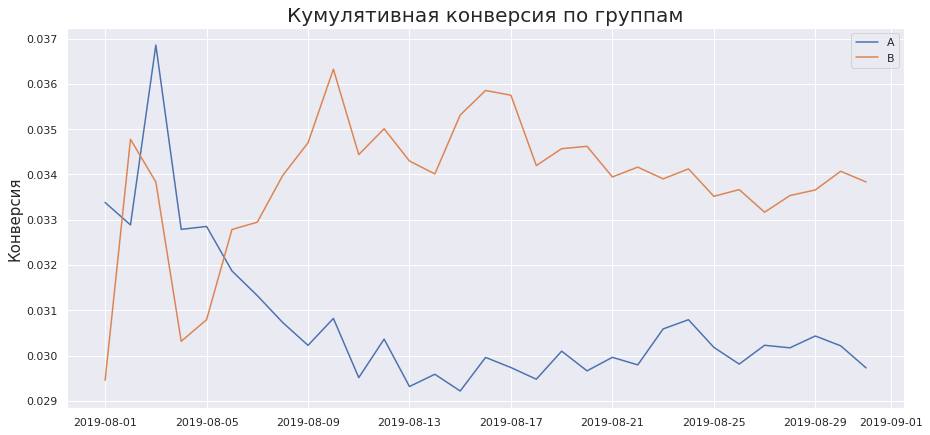

In [19]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# отделяем данные по группе A
cumulative_dataA = cumulative_data[cumulative_data['group'] == 'A']

# отделяем данные по группе B
cumulative_dataB = cumulative_data[cumulative_data['group'] == 'B']

# строим графики
plt.figure(figsize=(15,7))
plt.plot(cumulative_dataA['date'], cumulative_dataA['conversion'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам', fontsize=20)
plt.ylabel('Конверсия', fontsize=15)
plt.legend()
plt.show()

Группа **B** показывает лучшую конверсию.

#### Относительное изменение кумулятивной конверсии группы B к группе A

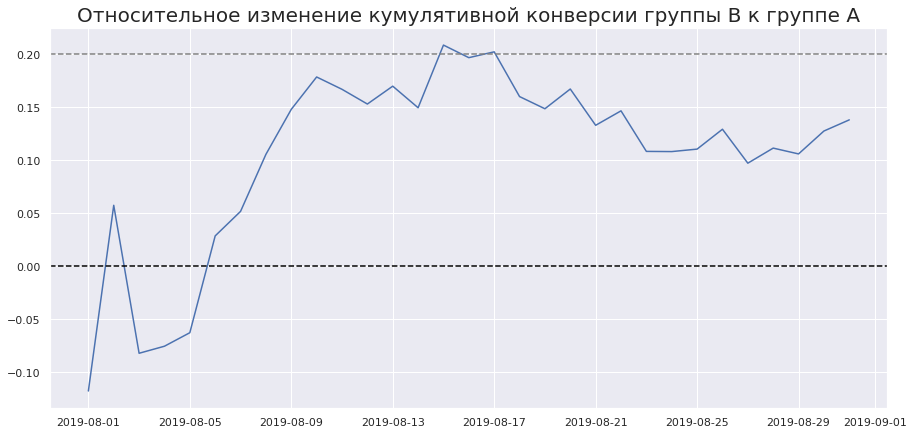

In [20]:
# объединяем таблицы конверсий
merged_cumulative_conversions = cumulative_dataA[['date','conversion']].merge(
    cumulative_dataB[['date','conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'])

# строим график относительного различия кумулятивной конверсии группы B к группе A
plt.figure(figsize=(15,7))
plt.plot(merged_cumulative_conversions['date'],
         merged_cumulative_conversions['conversionB'] /
         merged_cumulative_conversions['conversionA'] - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A', fontsize=20)
plt.show()

По этому графику также видно преимущество конверсии группы **B**.

### Анализ количества заказов по пользователям, стоимости заказов

#### Количество заказов по пользователям

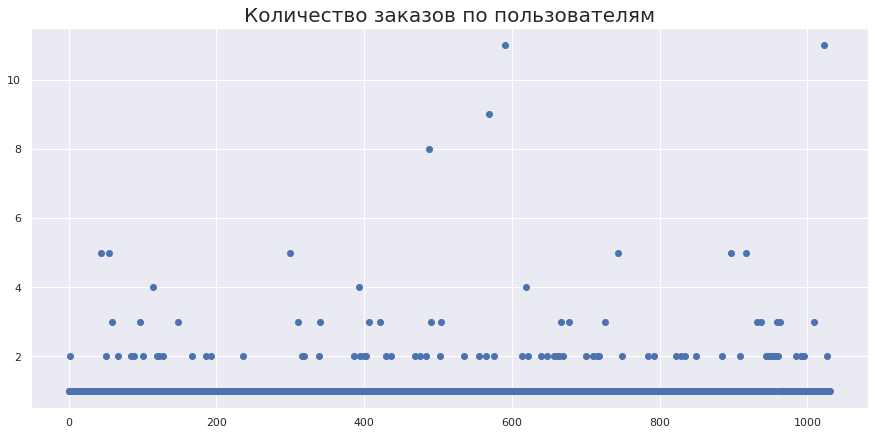

In [21]:
# группируем заказы по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['user_id', 'orders']

x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(15,7))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Количество заказов по пользователям', fontsize=20)
plt.show()

По графику видно, что `большинство пользователей` совершили от **1** до **3** заказов. Пользователей с **4 и более** заказов `значительно меньше`.

#### 95-й и 99-й перцентили количества заказов на пользователя

In [22]:
# находим перцентили
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Данный метод подтверждает, что **95%** пользователей `совершили до 2 заказов`, а **99%** пользователей - `до 4`. Следовательно, к `аномальным` пользователям можно отнести пользователей с **5 и более** заказами.

#### Стоимость заказов

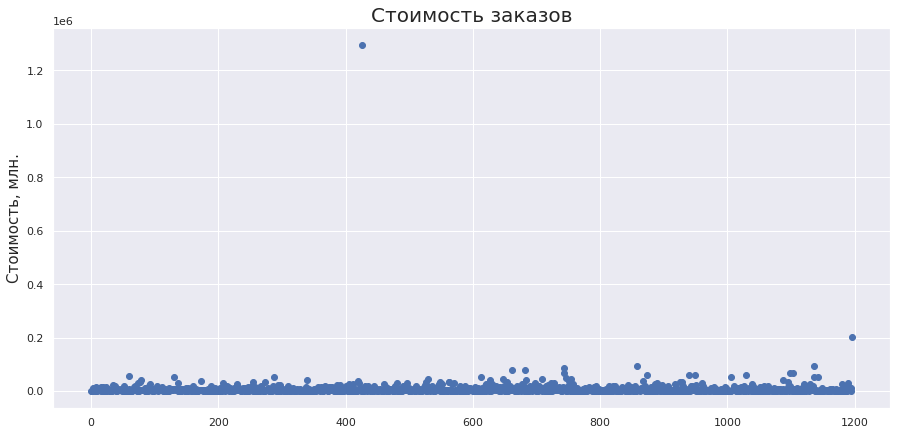

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15,7))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов', fontsize=20)
plt.ylabel('Стоимость, млн.', fontsize=15)
plt.show()

На графике виден один `очень крупный` заказ. Скорее всего именно он вызвал те `всплески` на графиках `выручки` и `среднего чека`. Также есть заказ в районе `200 тысяч`, остальные заказы `значительно меньше`.

#### 95-й и 99-й перцентили стоимости заказов

In [24]:
# находим перцентили
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


**95%** заказов стоили `не дороже` **28000** и **99%** - не дороже **58233,2**. Отнесём к `аномальным` заказам все заказы, дороже **60000**.

### Анализ статистической значимости

#### Статистическая значимость различий конверсий между группами по «сырым» данным

In [25]:
# составляем таблицу с количеством покупателей, заказов и их стоимостью за день по группам и всех этих данных с накоплением
visitors_dailyA = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_dailyA.columns = ['date', 'visitors_per_dateA']

visitors_cummulativeA = visitors_dailyA.apply(
    lambda x: visitors_dailyA[visitors_dailyA['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateA': 'sum'}
    ),
    axis=1,
)
visitors_cummulativeA.columns = ['date', 'visitors_cummulativeA']

visitors_dailyB = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_dailyB.columns = ['date', 'visitors_per_dateB']

visitors_cummulativeB = visitors_dailyB.apply(
    lambda x: visitors_dailyB[visitors_dailyB['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateB': 'sum'}
    ),
    axis=1,
)
visitors_cummulativeB.columns = ['date', 'visitors_cummulativeB']

orders_dailyA = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_dailyA.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

orders_cummulativeA = orders_dailyA.apply(
    lambda x: orders_dailyA[orders_dailyA['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateA': 'sum', 'revenue_per_dateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_cummulativeA.columns = [
    'date',
    'orders_cummulativeA',
    'revenue_cummulativeA',
]

orders_dailyB = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_dailyB.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

orders_cummulativeB = orders_dailyB.apply(
    lambda x: orders_dailyB[orders_dailyB['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateB': 'sum', 'revenue_per_dateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_cummulativeB.columns = [
    'date',
    'orders_cummulativeB',
    'revenue_cummulativeB',
]

data = (
    orders_dailyA.merge(
        orders_dailyB,
        left_on='date',
        right_on='date',
        how='left'
    )
    .merge(orders_cummulativeA, left_on='date', right_on='date', how='left')
    .merge(orders_cummulativeB, left_on='date', right_on='date', how='left')
    .merge(visitors_dailyA, left_on='date', right_on='date', how='left')
    .merge(visitors_dailyB, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulativeA, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulativeB, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,orders_per_dateA,revenue_per_dateA,orders_per_dateB,revenue_per_dateB,orders_cummulativeA,revenue_cummulativeA,orders_cummulativeB,revenue_cummulativeB,visitors_per_dateA,visitors_per_dateB,visitors_cummulativeA,visitors_cummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


В итоге у нас таблица со следующими данными:
- **date** - дата
- **orders_per_dateA** - количество заказов в выбранную дату в группе A
- **revenue_per_dateA** - суммарная выручка в выбранную дату в группе A
- **orders_per_dateB** - количество заказов в выбранную дату в группе B
- **revenue_per_dateB** - суммарная выручка в выбранную дату в группе B
- **orders_cummulativeA** - суммарное число заказов до выбранной даты включительно в группе A
- **revenue_cummulativeA** - суммарная выручка до выбранной даты включительно в группе A
- **orders_cummulativeB** - суммарное количество заказов до выбранной даты включительно в группе B
- **revenue_cummulativeB** - суммарная выручка до выбранной даты включительно в группе B
- **visitors_per_dateA** - количество пользователей в выбранную дату в группе A
- **visitors_per_dateB** - количество пользователей в выбранную дату в группе B
- **visitors_cummulativeA** - количество пользователей до выбранной даты включительно в группе A
- **visitors_cummulativeB** - количество пользователей до выбранной даты включительно в группе B

In [26]:
# группируем покупателей с заказами
orders_by_usersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique})
)
orders_by_usersA.columns = ['visitor_id', 'orders']

orders_by_usersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique})
)
orders_by_usersB.columns = ['visitor_id', 'orders']

pd.Series(0, index=np.arange(data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])), name='orders')

# создаём переменные для проверки тестом Манна-Уитни
sampleA = pd.concat(
    [
        orders_by_usersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        orders_by_usersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы:
* H0 - по сырым данным конверсии групп **A** и **B** равны
* H1 - по сырым данным конверсии групп **A** и **B** не равны

Уровень значимости установим равным 0.05

In [27]:
# создаём функцию для проверки гипотез
# применяем тест Манна-Уитни
def hyp_check(a, b):
    alpha = 0.05
    p_value = st.mannwhitneyu(a, b)[1]
    print('P-value = {0:.3f}'.format(p_value))
    
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: нет оснований считать показатели групп равными')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: есть основания считать показатели групп равными')
    
    print('Различие B к A равно {0:.2%}'.format(b.mean() / a.mean() - 1))
    
hyp_check(sampleA, sampleB)

P-value = 0.017
Отвергаем нулевую гипотезу: нет оснований считать показатели групп равными
Различие B к A равно 13.81%


По `"сырым"` данным `конверсии` различаются на **13.81%**.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:
* H0 - по сырым данным средний чек группы **A** равен среднему чеку группы **B**
* H1 - по сырым данным средний чек группы **A** не равен среднему чеку группы **B**

Уровень значимости установим равным 0.05

In [28]:
# применяем тест Манна-Уитни
hyp_check(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])

P-value = 0.729
Не получилось отвергнуть нулевую гипотезу: есть основания считать показатели групп равными
Различие B к A равно 25.87%


На средний чек существенно влияют выбросы и, хотя тест говорит о близких значениях средних чеков, по `"сырым"` данным `средний чек` различается на **25.87%**.

#### Статистическая значимость различий конверсий между группами по «очищенным» данным

In [29]:
# фильтруем найденных ранее аномальных покупателей из данных
users_with_many_orders = pd.concat(
    [
        orders_by_usersA[orders_by_usersA['orders'] > 4]['visitor_id'],
        orders_by_usersB[orders_by_usersB['orders'] > 4]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 60000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Всего аномальных покупателей:', abnormal_users.shape[0]) 

sample_filteredA = pd.concat(
    [
        orders_by_usersA[
            np.logical_not(orders_by_usersA['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_filteredB = pd.concat(
    [
        orders_by_usersB[
            np.logical_not(orders_by_usersB['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Всего аномальных покупателей: 14


Сформулируем гипотезы:
* H0 - по очищенным данным конверсии групп **A** и **B** равны
* H1 - по очищенным данным конверсии групп **A** и **B** не равны

Уровень значимости установим равным 0.05

In [30]:
# применяем тест Манна-Уитни
hyp_check(sample_filteredA, sample_filteredB)

P-value = 0.013
Отвергаем нулевую гипотезу: нет оснований считать показатели групп равными
Различие B к A равно 15.51%


После очистки данных `результат не изменился`, а различие в сторону группы **B** даже `увеличилось`.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:
* H0 - по очищенным данным средний чек группы **A** равен среднему чеку группы **B**
* H1 - по очищенным данным средний чек группы **A** не равен среднему чеку группы **B**

Уровень значимости установим равным 0.05

In [31]:
# применяем тест Манна-Уитни
hyp_check(
    orders[(orders['group'] == 'A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'],
    orders[(orders['group'] == 'B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
)

P-value = 0.814
Не получилось отвергнуть нулевую гипотезу: есть основания считать показатели групп равными
Различие B к A равно 0.74%


После очистки данных `процентное различие` существенно `сократилось`, однако сам `результат остался тем же`: гипотезу отвергнуть не получилось, а значит можно считать `средние чеки` в двух группах `равными`.

## Вывод:
По итогам исследования выявлено, что есть `статистически значимое различие конверсий` групп **A** и **B**. Данное различие прослеживается как по `сырым`, так и по `очищенным` данным. `Конверсия` группы **B** выше примерно на **15%**.\
Что касается различий по размеру `среднего чека`, то их `не выявлено` ни по `сырым`, ни по `очищенным` данным. Следовательно, можно считать, что `средние чеки` данных групп примерно `равны`.\
Исходя из данной информации, а также из данных графиков `выручки`, `кумулятивной конверсии` и `относительного изменения кумулятивной конверсии`, можно принять решение о **победе группы B** и **остановке теста**.